# Google stock price prediction with LSTM

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

/home/luis/Projects/ml-playground/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luis/Projects/ml-playground/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luis/Projects/ml-playground/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luis/Projects/ml-playground/

## Data loading and exploration

In [2]:
# Get the data of the stock GOOGL
data = yf.download('GOOGL','2009-01-01','2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-12-31,152.252258,155.655655,151.456451,153.978973,153.978973,5767800
2009-01-02,154.454453,161.071075,152.902908,160.820816,160.820816,7213700
2009-01-05,160.660660,165.785782,157.657654,164.189194,164.189194,9768200
2009-01-06,166.656662,170.570572,163.358353,167.197205,167.197205,12837500
2009-01-07,164.324326,165.620621,159.534531,161.166168,161.166168,8980000


## Data preprocessing

In [4]:
data = data.values

In [5]:
# Construction of the time series
len_of_series = 29

data_inputs, data_target = [], []
for i in range(len_of_series, len(data)):
    data_inputs.append(data[i-len_of_series:i, :])
    data_target.append(data[i, 0])
    
data_inputs, data_target = np.array(data_inputs), np.array(data_target)
data_target = data_target[:, np.newaxis]

print(f'Inputs shape: {data_inputs.shape}')
print(f'Target shape: {data_target.shape}')

Inputs shape: (2488, 29, 6)
Target shape: (2488, 1)


In [6]:
# Data split
splits_percentage = [0.7, 0.15, 0.15] # Train, Validation, Test

indexes = [i for i in range(data_inputs.shape[0])]
train_split_indexes = indexes[0:int(len(indexes)*splits_percentage[0])]
val_split_indexes = indexes[int(len(indexes)*splits_percentage[0]):int(len(indexes)*(splits_percentage[0] + splits_percentage[1]))]
test_split_indexes = indexes[int(len(indexes)*(1 - splits_percentage[2])):]

train_inputs = data_inputs[train_split_indexes, :, :]
train_target = data_target[train_split_indexes, :]
validation_inputs = data_inputs[val_split_indexes, :, :]
validation_target = data_target[val_split_indexes, :]
test_inputs = data_inputs[test_split_indexes, :, :]
test_target = data_target[test_split_indexes,:]

In [7]:
# Data normalization
sc_inputs = []
for feature in range(train_inputs.shape[2]):
    sc_inputs.append(MinMaxScaler())
    train_inputs[:, :, feature] = sc_inputs[feature].fit_transform(train_inputs[:, :, feature])
    validation_inputs[:, :, feature] = sc_inputs[feature].transform(validation_inputs[:, :, feature])
    test_inputs[:, :, feature] = sc_inputs[feature].transform(test_inputs[:, :, feature])

sc_target = MinMaxScaler()
train_target = sc_target.fit_transform(train_target)
validation_target = sc_target.transform(validation_target)
test_target = sc_target.transform(test_target)

## Model definition

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_inputs.shape[1], train_inputs.shape[2])))
model.add(Dropout(.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=10, restore_best_weights=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
hisotry = model.fit(train_inputs, train_target, epochs=100, batch_size=32, 
                    validation_data=(validation_inputs, validation_target), callbacks=[es])

Train on 1741 samples, validate on 373 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
1741/1741 [==============================] - 4s 2ms/sample - loss: 0.0117 - acc: 0.0011 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 2/100
1741/1741 [==============================] - 2s 1ms/sample - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 3/100
1741/1741 [==============================] - 2s 1ms/sample - loss: 0.0011 - acc: 0.0011 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 4/100
1741/1741 [==============================] - 2s 1ms/sample - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 5/100
1741/1741 [==============================] - 2s 1ms/sample - loss: 0.0011 - acc: 0.0011 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 6/100
1741/1741 [==============================] - 2s 1ms/sample - loss: 9.7488e-04 - acc: 0.0011 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 7/1

## Results analysis

In [10]:
eval_train = model.evaluate(train_inputs, train_target, batch_size=32)
eval_val = model.evaluate(validation_inputs, validation_target, batch_size=32)
eval_test = model.evaluate(test_inputs, test_target, batch_size=32)

374/374 [==============================] - 0s 354us/sample - loss: 0.0041 - acc: 0.0000e+00


In [11]:
train_pred = model.predict(train_inputs, batch_size=32)
val_pred = model.predict(validation_inputs, batch_size=32)
test_pred = model.predict(test_inputs, batch_size=32)

train_pred = sc_target.inverse_transform(train_pred)
val_pred = sc_target.inverse_transform(val_pred)
test_pred = sc_target.inverse_transform(test_pred)

train_target = sc_target.inverse_transform(train_target)
validation_target = sc_target.inverse_transform(validation_target)
test_target = sc_target.inverse_transform(test_target)

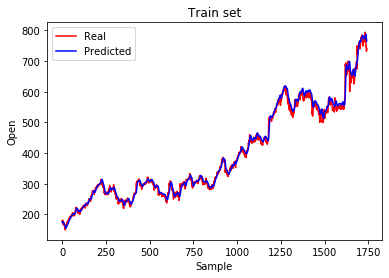

In [12]:
plt.plot(train_target, color='red', label='Real')
plt.plot(train_pred, color='blue', label='Predicted')
plt.title('Train set')
plt.xlabel('Sample')
plt.ylabel('Open')
plt.legend()
plt.show()

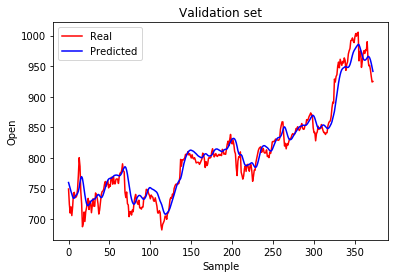

In [13]:
plt.plot(validation_target, color='red', label='Real')
plt.plot(val_pred, color='blue', label='Predicted')
plt.title('Validation set')
plt.xlabel('Sample')
plt.ylabel('Open')
plt.legend()
plt.show()

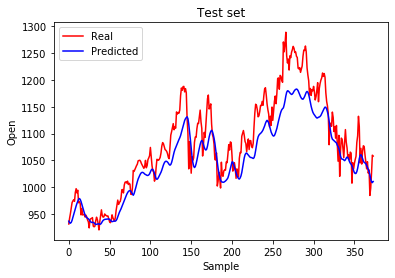

In [14]:
plt.plot(test_target, color='red', label='Real')
plt.plot(test_pred, color='blue', label='Predicted')
plt.title('Test set')
plt.xlabel('Sample')
plt.ylabel('Open')
plt.legend()
plt.show()